In [17]:
# Import necessary libraries for data manipulation, visualization, and machine learning.
import pandas as pd  # for data processing and CSV file I/O
import numpy as np  # for numerical operations
import plotly.express as px  # for interactive plotting
from sklearn.preprocessing import MinMaxScaler  # for feature scaling
import os  # for interacting with the operating system
import gc  # for garbage collection to manage memory
import time  # for time-related functions
import warnings  # for handling warnings
from warnings import simplefilter  # to filter warnings
from itertools import combinations  # for creating combinations

# Import additional libraries for machine learning and data visualization.
import joblib  # for saving and loading models
import seaborn as sns  # for statistical data visualization
import matplotlib.pyplot as plt  # for plotting
from catboost import CatBoostRegressor, Pool  # for CatBoost model and data pool
from catboost import EFeaturesSelectionAlgorithm, EShapCalcType  # for feature selection in CatBoost
from sklearn.linear_model import LinearRegression  # for linear regression modeling
from sklearn.metrics import mean_absolute_error  # for evaluating model performance
from sklearn.linear_model import Ridge

# Configure warnings to ignore specific categories.
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Import functions for splitting data and evaluating models.
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import libraries for hyperparameter tuning.
import optuna as opt  # for hyperparameter tuning

Getting Data

In [2]:
# Load the training dataset from a CSV file into a pandas DataFrame.
train = pd.read_csv("train.csv")

In [3]:
# Display the first 5 rows of the training dataset for inspection.
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
# Determine the number of rows and columns in the training dataset.
num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  5237980
Number of Columns:  17


In [5]:
# Remove rows with missing values in the 'target' column from the training dataset.
train = train.dropna(subset=["target"])

# 🔁 Reset the index of the DataFrame and apply the changes in place
train.reset_index(drop=True, inplace=True)

# Re-evaluate the shape of the DataFrame after removing missing values.
num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  5237892
Number of Columns:  17


Additional Features

In [6]:
#get positive and negative changes based on the reference price
pos_changes = train['reference_price'].diff().clip(lower=1)
neg_changes = train['reference_price'].diff().clip(upper=1)

#calculate the formula
train['RSI'] = 1 - (100/(1 + pos_changes/neg_changes))

In [7]:
# Define the window size for the moving average
window_size = 2

# Compute the moving averages for each stock and the 'wap' column
train['SMA'] = train.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=window_size,  min_periods=1).mean())

In [8]:
#Compute how far the last traded price is from the reference price.
train['price_deviation'] = ((train['far_price'] / train['matched_size']) - train['reference_price']) / train['reference_price']

In [9]:
#⚡Optiver 🚀Robust Best ⚡ Single Model features

train["volume"] = train.eval("ask_size + bid_size")
train["mid_price"] = train.eval("(ask_price + bid_price) / 2")
train["liquidity_imbalance"] = train.eval("(bid_size-ask_size)/(bid_size+ask_size)")
train["matched_imbalance"] = train.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
train["size_imbalance"] = train.eval("bid_size / ask_size")
train["price_spread"] = train["ask_price"] - train["bid_price"]
train['market_urgency'] = train['price_spread'] * train['liquidity_imbalance']

In [10]:
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,RSI,SMA,price_deviation,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,NaN,1.0,NaN,69144.53,0.999919,0.754340,-0.615890,7.141326,0.000214,0.000161
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,0.991601,1.0,NaN,23838.13,1.000278,-0.728751,-0.815787,0.156905,0.000764,-0.000557
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,1.033511,1.0,NaN,56951.00,0.999850,0.332935,-0.714567,1.998210,0.000895,0.000298
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,0.939037,1.0,NaN,481357.30,1.000107,-0.990340,-0.213547,0.004853,0.000215,-0.000213
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,1.063941,1.0,NaN,16919.64,0.999705,0.948687,-0.951109,37.976365,0.000622,0.000590


In [11]:
train.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,RSI,SMA,price_deviation,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
5237887,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,...,1.118841,1.000343,-1.0,352119.44,1.000376,-0.816784,-0.841104,0.100847,0.000117,-0.000096
5237888,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,...,0.967411,1.000817,-1.0,298501.47,1.000771,0.374254,-0.926706,2.196184,0.000257,0.000096
5237889,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,...,1.487768,0.995892,-1.0,196828.98,0.995836,-0.829388,-1.000000,0.093262,0.000094,-0.000078
5237890,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,...,0.659066,0.999018,-1.0,795524.72,0.999090,-0.684154,-0.979099,0.187540,0.000240,-0.000164
5237891,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,...,0.708950,1.002134,-1.0,550249.00,1.002288,-0.091024,-0.854820,0.833139,0.000318,-0.000029


Setting up training and testing data

In [12]:
# Drop certain columns from the dataset and remove missing values.
columns_to_drop = ['far_price', 'near_price']
train = train.drop(columns_to_drop, axis=1)
train = train.dropna()  

# Split the dataset into features (X) and target variable (y).
X = train.drop('target', axis=1)
y = train['target']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset the index of the training data after splitting.
train.reset_index(drop=True, inplace=True)

# Re-evaluate the shape of the training data after splitting.
num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  2343564
Number of Columns:  25


In [13]:
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,...,RSI,SMA,price_deviation,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
0,0,0,300,0.00,0,1.000241,26670118.88,1.000026,19319.31,1.000241,...,1.056131,1.000266,-1.0,35468.86,1.000134,0.089367,-1.000000,1.196275,0.000215,0.000019
1,1,0,300,242332.96,-1,1.000073,3242054.27,0.999544,43205.40,1.000308,...,1.016803,1.000180,-1.0,45248.16,0.999926,0.909709,-0.860904,21.150502,0.000764,0.000695
2,2,0,300,0.00,0,1.000193,4671376.00,0.999035,18971.00,1.001036,...,0.988001,0.999671,-1.0,78659.26,1.000036,-0.517641,-1.000000,0.317835,0.002001,-0.001036
3,3,0,300,2914730.16,1,0.999870,41057776.66,0.999827,25569.50,1.000042,...,1.032310,0.999948,-1.0,63467.00,0.999935,-0.194243,-0.867429,0.674701,0.000215,-0.000042
4,4,0,300,3396923.02,1,0.998496,38356174.88,0.998357,14446.00,0.998703,...,1.137589,0.998458,-1.0,17047.18,0.998530,0.694826,-0.837285,5.553633,0.000346,0.000240


Catboost with GridSearch Hyperparameter Optimization

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Grid Search.
# Here, we are specifying the combinations of parameters we want to try.
param_grid = {
    'depth': [6, 8, 10],  # 3 options for 'depth'
    'learning_rate': [0.01, 0.05, 0.1],  # 3 options for 'learning_rate'
    'iterations': [100, 200, 300]  # 3 options for 'iterations'
}

# Initialize CatBoost Regressor
categorical_features_names = ['imbalance_buy_sell_flag', 'row_id']
catboost_grid_model = CatBoostRegressor(loss_function='RMSE', random_seed=42, cat_features=categorical_features_names)

# Initialize GridSearchCV.
# This will test every combination of parameters in the param_grid.
# Since there are 3 parameters, each with 3 options, this will result in 3*3*3 = 27 total combinations.
# The cv=3 argument means that for each combination, 3-fold cross-validation is used.
grid_search = GridSearchCV(catboost_grid_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=10)

# Perform Grid Search.
# This will fit the model 27 times (for each combination of parameters) and each time with 3-fold CV.
# So, the model is actually being fit 27 * 3 = 81 times in total.
grid_search.fit(X_train, y_train)

# Display the best parameters and best score (mean squared error in this case).
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START depth=6, iterations=100, learning_rate=0.01................


KeyboardInterrupt: 

Hyperparameter Tuning using Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution for Randomized Search.
# Unlike Grid Search, we provide a range or distribution for each parameter.
param_dist = {
    'depth': [6, 8, 10],  # 3 options for 'depth'
    'learning_rate': uniform(0.01, 0.1),  # Continuous range for 'learning_rate'
    # 'iterations': [100, 200, 300]  # 3 options for 'iterations'
    #  small test iteration
    'iterations': [1, 2, 3]
}

# Initialize RandomizedSearchCV.
# This will randomly sample parameter combinations from the distributions.
# The n_iter parameter defines how many different parameter combinations to try.
# Here, 10 iterations means 10 different combinations will be tried.
# Initialize CatBoost Regressor
catboost_random_model = CatBoostRegressor(loss_function='RMSE', random_seed=42) # smae as catboost_grid_model
random_search = RandomizedSearchCV(catboost_random_model, param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=3, verbose=10, random_state=42)

# Perform Randomized Search.
# The model will be fit 10 times (for each randomly sampled combination) and each time with 3-fold CV.
# So, the model is actually being fit 10 * 3 = 30 times in total.
random_search.fit(X_train, y_train)

# Display the best parameters and best score.
print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Hyperparameter Optimization with Optuna

In [ ]:
import optuna

# Define the objective function that Optuna will optimize.
# Optuna will try to find the best values for 'iterations', 'depth', and 'learning_rate' to minimize the returned value (MSE in this case).
def objective(trial):
    # Define the hyperparameters to optimize.
    # Optuna will sample these during each trial.
    param = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
    }

    # Train the model with the current set of hyperparameters.
    model = CatBoostRegressor(**param, loss_function='RMSE', random_seed=42)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, early_stopping_rounds=10)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create an Optuna study which is a single optimization run.
study = optuna.create_study(direction='minimize')

# Optuna will perform 10 trials.
# In each trial, Optuna will call the 'objective' function with a different set of hyperparameters.
# These hyperparameters are chosen based on the previous trials to minimize the objective function.
study.optimize(objective, n_trials=10)

# Display the best parameters and best score found by Optuna.
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)


Evaluate Best Models from Each Tuning Method

In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluation function using MAE
def evaluate_model_mae(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    mae = mean_absolute_error(y_test, y_pred)
    return mae, end_time - start_time

In [ ]:
# Evaluate Grid Search Best Model
best_grid_model = grid_search.best_estimator_
mae_grid, time_grid = evaluate_model_mae(best_grid_model, X_test, y_test)

# Evaluate Randomized Search Best Model
best_random_model = random_search.best_estimator_
mae_random, time_random = evaluate_model_mae(best_random_model, X_test, y_test)

# Evaluate Optuna Best Model
optuna_params = study.best_params
optuna_model = CatBoostRegressor(**optuna_params, loss_function='RMSE')
optuna_model.fit(X_train, y_train, verbose=0)
mae_optuna, time_optuna = evaluate_model_mae(optuna_model, X_test, y_test)

In [ ]:
# Compare the best hyperparameters and MAE from each method
print("Best Grid Search Parameters:", grid_search.best_params_, "MAE:", mae_grid)
print("Best Randomized Search Parameters:", random_search.best_params_, "MAE:", mae_random)
print("Best Optuna Parameters:", study.best_params, "MAE:", mae_optuna)

Linear Regression base model for testing

In [18]:
# Create a Ridge regression model
alpha = 1.0  # Regularization strength (adjust as needed)
ridge_model = Ridge(alpha=alpha)

# Train the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 69.15827282122486


Catboost fitting with best features from above

In [19]:
# Initialize and train a CatBoost Regressor model with specific parameters.
categorical_features_names = ['imbalance_buy_sell_flag', 'row_id']
catboost_model = CatBoostRegressor(depth=10, iterations=300, learning_rate=0.1, loss_function='RMSE', random_seed=42, cat_features=categorical_features_names)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

0:	learn: 8.3580313	test: 8.3675391	best: 8.3675391 (0)	total: 5.19s	remaining: 25m 53s
10:	learn: 8.2704545	test: 8.2889012	best: 8.2889012 (10)	total: 49.1s	remaining: 21m 30s
20:	learn: 8.2284816	test: 8.2575585	best: 8.2575585 (20)	total: 1m 34s	remaining: 20m 56s
30:	learn: 8.1958120	test: 8.2353296	best: 8.2353296 (30)	total: 2m 18s	remaining: 20m 4s
40:	learn: 8.1727557	test: 8.2238116	best: 8.2238116 (40)	total: 3m 2s	remaining: 19m 10s
50:	learn: 8.1527978	test: 8.2146061	best: 8.2146061 (50)	total: 3m 44s	remaining: 18m 18s
60:	learn: 8.1331443	test: 8.2045714	best: 8.2045714 (60)	total: 4m 31s	remaining: 17m 41s
70:	learn: 8.1161817	test: 8.1963624	best: 8.1963624 (70)	total: 5m 16s	remaining: 17m 1s
80:	learn: 8.1018314	test: 8.1885351	best: 8.1885351 (80)	total: 6m 4s	remaining: 16m 25s
90:	learn: 8.0869981	test: 8.1802547	best: 8.1802547 (90)	total: 6m 51s	remaining: 15m 44s
100:	learn: 8.0733059	test: 8.1721173	best: 8.1721173 (100)	total: 7m 39s	remaining: 15m 4s
110:	l

Catboost error

In [20]:
# Make predictions using the trained CatBoost model.
y_pred = catboost_model.predict(X_test)
# Evaluate the CatBoost model using Mean Squared Error (MSE).
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 65.18168145430103


Feature Importance

In [21]:
# Obtain feature importances from the CatBoost model.
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns
# Create a DataFrame for feature importances and sort it.
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                    Feature  Importance
2         seconds_in_bucket   11.978715
22             price_spread    8.536639
23           market_urgency    7.916040
6              matched_size    7.174599
12                  time_id    6.314553
0                  stock_id    6.261877
20        matched_imbalance    6.213588
14                      RSI    5.729901
1                   date_id    5.039533
3            imbalance_size    4.173333
5           reference_price    3.755424
16          price_deviation    3.626687
9                 ask_price    3.610815
7                 bid_price    3.201613
18                mid_price    2.646848
11                      wap    2.541363
10                 ask_size    2.474883
15                      SMA    2.221051
8                  bid_size    1.816961
17                   volume    1.567942
4   imbalance_buy_sell_flag    1.501084
19      liquidity_imbalance    1.065063
21           size_imbalance    0.631490
13                   row_id    0.000000


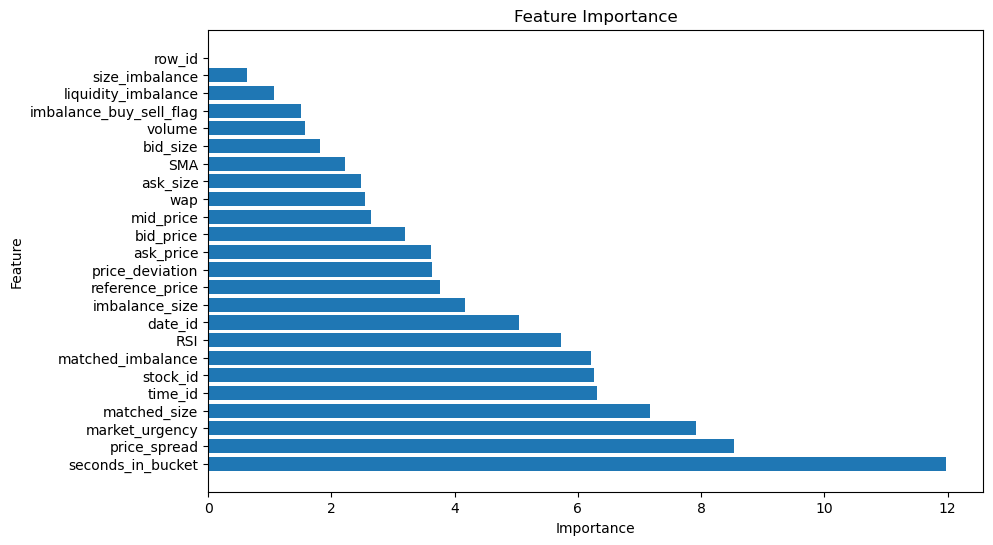

In [22]:
# Obtain feature importances from the CatBoost model.
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a DataFrame for feature importances and sort it.
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Rescidual Plot

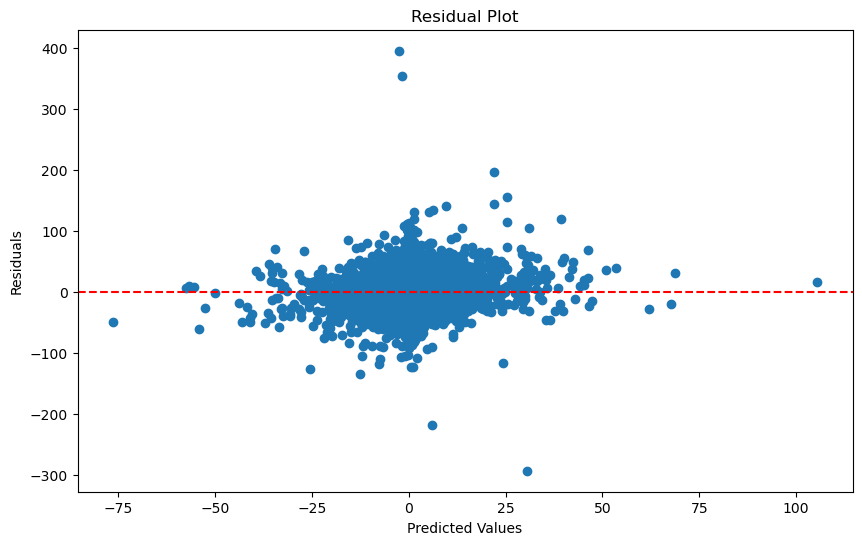

In [23]:
y_pred = catboost_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Analyzing Errors

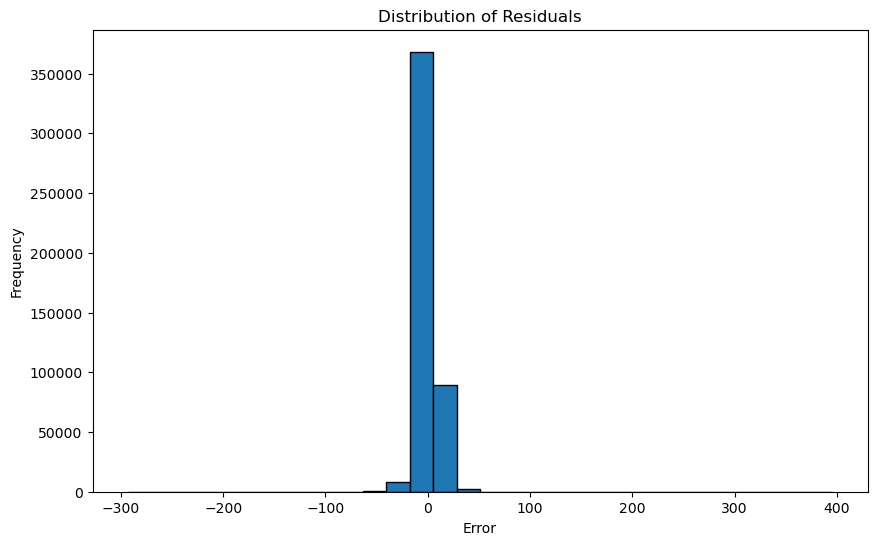

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

Prediction Error Plot

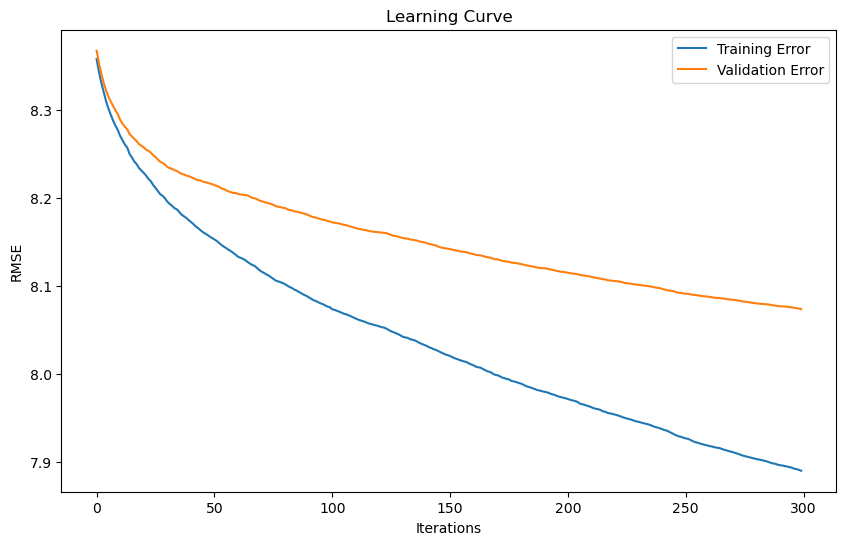

In [25]:
results = catboost_model.get_evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['learn']['RMSE'], label='Training Error')
plt.plot(results['validation']['RMSE'], label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.show()